# Sentiment Analysis Using Bi-LSTM

In [99]:
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [92]:
dataset=pd.read_csv('Ola_Dataset1.csv')
dataset.head()

,Unnamed: 0,tweet,Subjectivity,Polarity,Analysis,label
0,0,not that it will matter to you no zamato swi...,1.00,1.0,Positive,1.0
1,1,Happy church day ⛪⛪ Marriott Hotel Downtown A...,1.00,0.8,Positive,1.0
2,2,Over drivers in London register on Ola Great ...,0.75,0.8,Positive,1.0
3,3,It would be great if you chain me in this ap...,0.75,0.8,Positive,1.0
4,4,Just wait Sir will sooner you face a welcome ...,0.90,0.8,Positive,1.0


In [93]:
#Removing the unnecessary columns.
dataset = dataset[['label','tweet']]

# Replacing the values.
dataset['tweet'] = dataset['tweet'].replace(4,1)

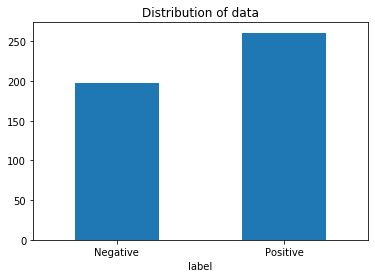

In [94]:
ax = dataset.groupby('label').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [95]:
contractions = pd.read_csv('contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    weet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [96]:
%%time
dataset['processed_text'] = dataset.tweet.apply(preprocess_apply)

Wall time: 50.3 ms


In [97]:
count=0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break
processedtext = list(dataset['processed_text'])
data_pos = processedtext[:263]
data_neg = processedtext[263:]

Text:   not that it will matter to you no zamato swiggy ola or amazon or flipkart Agra is cut off from the world and mind u in peak tourist season what a wonderful message will tourist take home on the govt of    
Processed:   not that it will matter to you no zamato swiggy ola or amazon or flipkart agra is cut off from the world and mind u in peak tourist season what a wonderful message will tourist take home on the govt of  
Text: Happy church day ⛪⛪  Marriott Hotel Downtown Abu Dhabi  httpstcoOVDosxpg
Processed: happy church day     marriott hotel downtown abu dhabi  httpstcoovdosxpg
Text: Over  drivers in London register on Ola Great job   httpstcocGJQUutve
Processed: over  drivers in london register on ola great job  httpstcocgjquutve
Text:   It would be great if you chain me in this appreciation
Processed:   it would be great if you chain me in this appreciation
Text:  Just wait Sir will sooner you face a welcome fire after shouting  hu 
Processed:  just wait sir will sooner you 

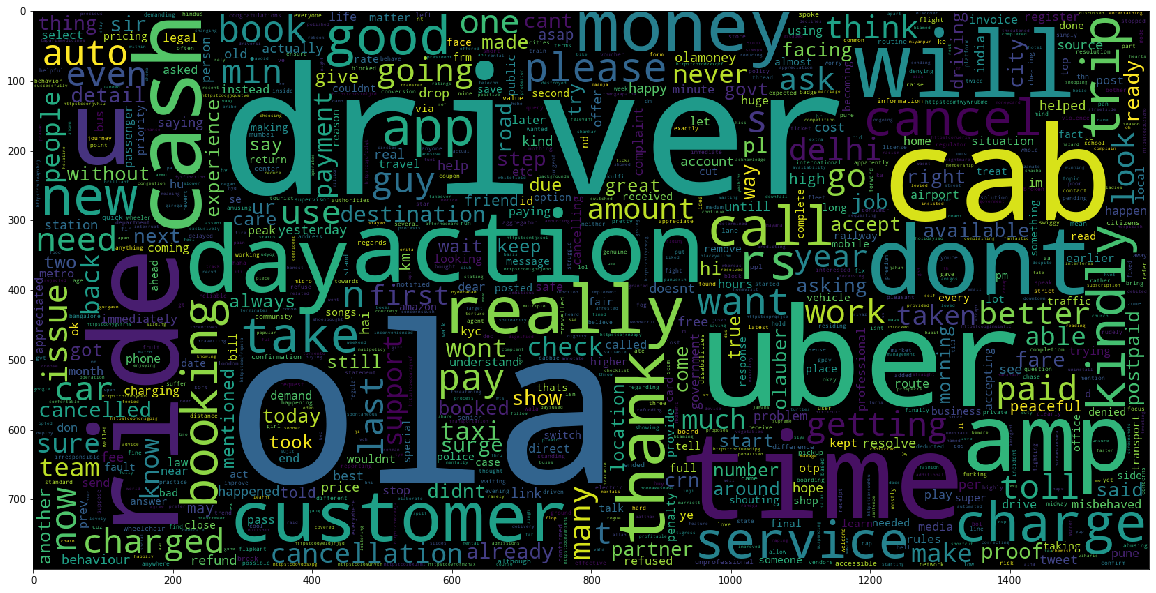

In [100]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

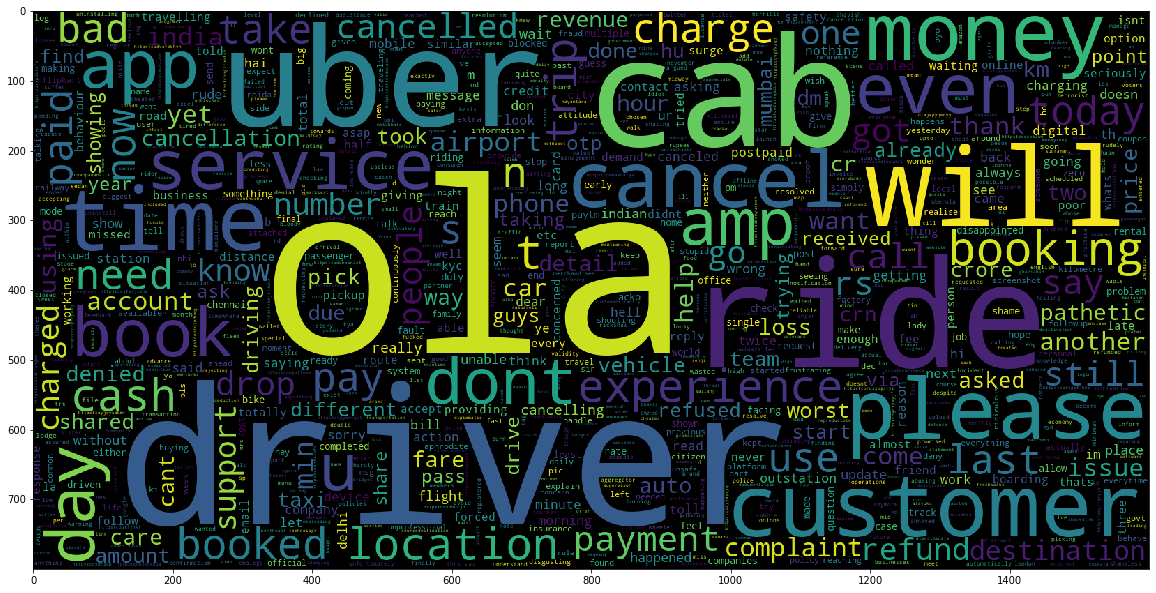

In [101]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [102]:
from sklearn.model_selection import train_test_split

In [10]:
tf.__version__

'2.3.0'

In [103]:
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['label'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.3, random_state = 71)
print('Data Split done.')

Data Split done.


In [104]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [105]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.vocab))

Vocabulary Length: 407
Wall time: 403 ms


In [106]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [107]:
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)

vocab_length = len(tokenizer.word_index) + 1
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 3157


In [108]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (483, 60)
X_test.shape : (207, 60)


In [109]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (3157, 100)


In [110]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [112]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length, 
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix], 
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(200, dropout=0.1, return_sequences=True)),
        Bidirectional(LSTM(200, dropout=0.1, return_sequences=True)),
        Bidirectional(LSTM(200, dropout=0.1, return_sequences=True)),
        Bidirectional(LSTM(200, dropout=0.1, return_sequences=True)),
        Conv1D(100, 10, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [113]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 100)           315700    
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 400)           481600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 400)           961600    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 400)           961600    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60, 400)           961600    
_________________________________________________________________
conv1d (Conv1D)              (None, 51, 100)           400100    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)           

In [57]:
len(embedded_docs),y.shape

(459, (459,))

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.4, random_state=101)

### Model Training

In [76]:
### Finally Training
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,batch_size=50)

Epoch 1/30
6/6 [==============================] - 0s 53ms/step - loss: 0.4278 - accuracy: 0.9127 - val_loss: 0.1212 - val_accuracy: 0.9674
Epoch 2/30
6/6 [==============================] - 0s 48ms/step - loss: 0.2199 - accuracy: 0.9382 - val_loss: 0.1236 - val_accuracy: 0.9457
Epoch 3/30
6/6 [==============================] - 0s 47ms/step - loss: 0.1227 - accuracy: 0.9491 - val_loss: 0.1283 - val_accuracy: 0.9565
Epoch 4/30
6/6 [==============================] - 0s 35ms/step - loss: 0.0651 - accuracy: 0.9855 - val_loss: 0.1208 - val_accuracy: 0.9620
Epoch 5/30
6/6 [==============================] - 0s 43ms/step - loss: 0.0417 - accuracy: 0.9927 - val_loss: 0.1200 - val_accuracy: 0.9565
Epoch 6/30
6/6 [==============================] - 0s 38ms/step - loss: 0.0292 - accuracy: 0.9964 - val_loss: 0.1204 - val_accuracy: 0.9565
Epoch 7/30
6/6 [==============================] - 0s 46ms/step - loss: 0.0236 - accuracy: 1.0000 - val_loss: 0.1232 - val_accuracy: 0.9565
Epoch 8/30
6/6 [===========

### Performance Metrics And Accuracy

In [77]:
y_pred=model.predict_classes(X_test)

In [78]:
from sklearn.metrics import confusion_matrix

In [79]:
confusion_matrix(y_test,y_pred)

array([[ 69,   5],
       [  4, 106]], dtype=int64)

In [80]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9510869565217391

In [81]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94        74
         1.0       0.95      0.96      0.96       110

    accuracy                           0.95       184
   macro avg       0.95      0.95      0.95       184
weighted avg       0.95      0.95      0.95       184



In [88]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

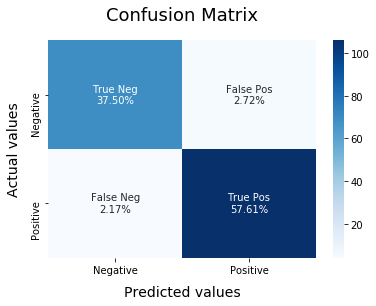

In [89]:

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)